Lets take a look at last weekends Knicks game against Houston at MSG

In [21]:
import requests

#get the status, opentime and closetime of market
ticker = "KXNBAGAME-26FEB21HOUNYK-NYK"
m = requests.get(f"https://api.elections.kalshi.com/trade-api/v2/markets/{ticker}")
m.raise_for_status()
market = m.json()["market"]
print(market["status"], market.get("open_time"), market.get("close_time"))

finalized 2026-02-19T17:07:00Z 2026-02-22T04:24:05Z


In [ ]:
# trade data
ticker = "KXNBAGAME-26FEB21HOUNYK-NYK"
params = {"ticker": ticker, "limit": 1000}
t = requests.get("https://api.elections.kalshi.com/trade-api/v2/markets/trades", params=params)
t.raise_for_status()
trades = t.json()["trades"]
print(len(trades), trades[:2])

1000 [{'count': 1677, 'count_fp': '1677.00', 'created_time': '2026-02-22T04:10:55.182849Z', 'no_price': 1, 'no_price_dollars': '0.0100', 'price': 0.99, 'taker_side': 'no', 'ticker': 'KXNBAGAME-26FEB21HOUNYK-NYK', 'trade_id': '83cc7375-5c6f-4e49-676a-7e13aebf1d06', 'yes_price': 99, 'yes_price_dollars': '0.9900'}, {'count': 1638, 'count_fp': '1638.00', 'created_time': '2026-02-22T04:10:55.043209Z', 'no_price': 1, 'no_price_dollars': '0.0100', 'price': 0.99, 'taker_side': 'no', 'ticker': 'KXNBAGAME-26FEB21HOUNYK-NYK', 'trade_id': 'af27ee8f-1f5a-40eb-4509-399beab16828', 'yes_price': 99, 'yes_price_dollars': '0.9900'}]


YES + NO ≈ $1.00 for a given market (equilibrium).
The YES price is commonly interpreted as the market-implied probability (e.g., $0.70 ≈ 70%).

In [37]:
import pandas as pd 

df = pd.DataFrame(trades)   # one row, columns = keys
df.head(5)
df[df['price'] == .51]


,count,count_fp,created_time,no_price,no_price_dollars,price,taker_side,ticker,trade_id,yes_price,yes_price_dollars
150,101,101.00,2026-02-22T04:10:39.448481Z,49,0.4900,0.51,no,KXNBAGAME-26FEB21HOUNYK-NYK,296ba56b-4c88-518a-e42f-3bb8b5436c44,51,0.5100
335,144,144.00,2026-02-22T04:10:02.329467Z,49,0.4900,0.51,no,KXNBAGAME-26FEB21HOUNYK-NYK,f7a0354e-6fd2-4c4d-137c-b86ca010881f,51,0.5100


Let's clean up the data and run this in 1 minute buckets (does anyone remember resampling from their time series analysis class)

In [ ]:
df = pd.DataFrame(trades).copy()
# Parse types
df["created_time"] = pd.to_datetime(df["created_time"], utc=True, errors="coerce")
df["yes_price_dollars"] = pd.to_numeric(df["yes_price_dollars"], errors="coerce")
df["count_fp"] = pd.to_numeric(df.get("count_fp", df.get("count")), errors="coerce")
# Sort + set index for resample
df = df.dropna(subset=["created_time", "yes_price_dollars"]).sort_values("created_time")
df = df.set_index("created_time") #resampling requires a datetime index
# 1-minute candles + volume
minute = df.resample("1min").agg(
    open=("yes_price_dollars", "first"),
    high=("yes_price_dollars", "max"),
    low =("yes_price_dollars", "min"),
    close=("yes_price_dollars", "last"),
    volume=("count_fp", "sum"),
)
# Keep only minutes with at least one trade
minute = minute.dropna(subset=["open"])

In [46]:
minute

,open,high,low,close,volume
created_time,,,,,
2026-02-22 04:06:00+00:00,0.98,0.99,0.95,0.98,10410.0
2026-02-22 04:07:00+00:00,0.96,0.99,0.96,0.99,88878.0
2026-02-22 04:08:00+00:00,0.99,0.99,0.97,0.97,266192.0
2026-02-22 04:09:00+00:00,0.97,0.99,0.95,0.96,69872.0
2026-02-22 04:10:00+00:00,0.95,0.99,0.13,0.99,279536.0


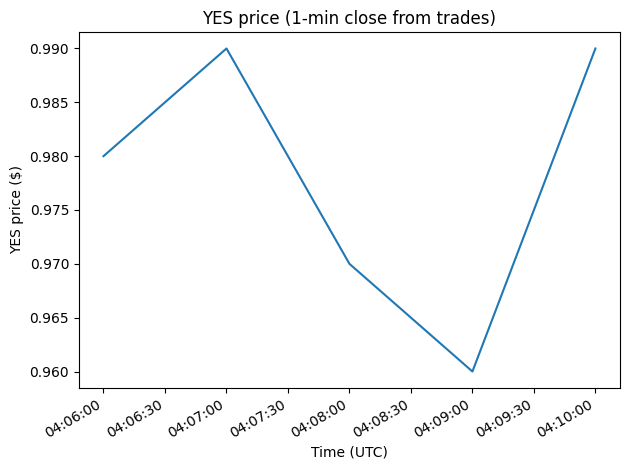

In [43]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(minute.index, minute["close"])
plt.xlabel("Time (UTC)")
plt.ylabel("YES price ($)")
plt.title("YES price (1-min close from trades)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()